In [1]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

import utils
import vision_transformer as vits

## モデルの読み込み

In [2]:
#!wget https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
patch_size = 8
model = vits.vit_small(patch_size=patch_size)

In [5]:
checkpoint = torch.load("dino_deitsmall8_pretrain.pth", map_location="cpu")

In [6]:
model.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

In [7]:
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

## 画像の読み込み

In [38]:
#response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
#response = requests.get("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01440764_tench.JPEG")
#response = requests.get("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01855672_goose.JPEG")
response = requests.get("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01494475_hammerhead.JPEG")
#response = requests.get("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01689811_alligator_lizard.JPEG")
#response = requests.get("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01532829_house_finch.JPEG")
#response = requests.get("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02444819_otter.JPEG")

In [39]:
img = Image.open(BytesIO(response.content))
img_pil = img.convert('RGB')

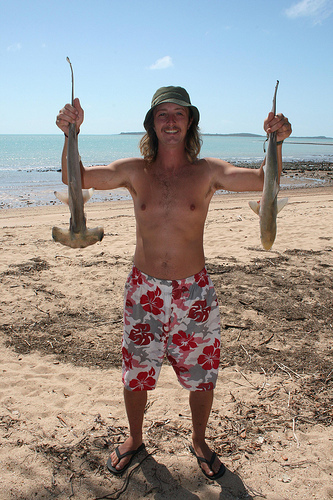

In [40]:
img_pil

## 注意の取り出し

In [41]:
transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
img = transform(img_pil)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

In [42]:
attentions = model.get_last_selfattention(img.to(device))

nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

In [43]:
attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

In [44]:
attentions.shape

(6, 496, 328)

In [45]:
attentions_mean = np.mean(attentions, axis=0)

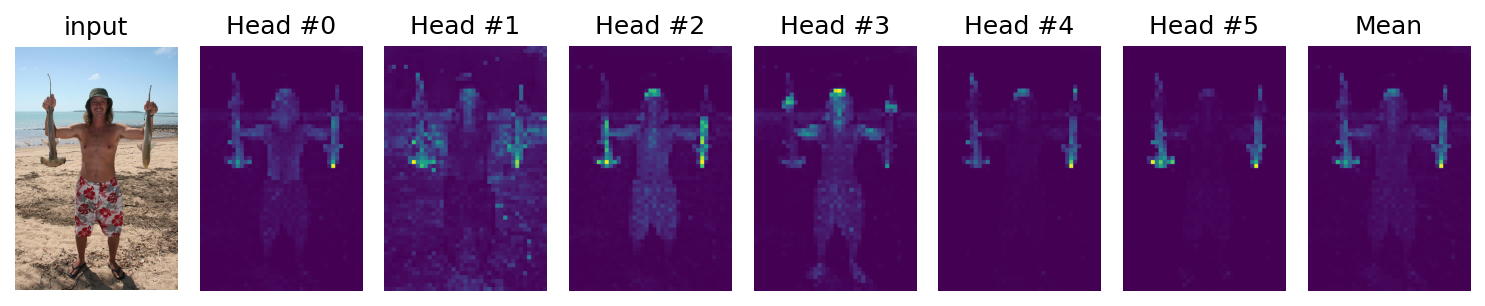

In [46]:
plt.figure(figsize=(10, 3), dpi=150)
plt.subplot(1, nh+2, 1)
plt.title("input")
plt.imshow(np.array(img_pil))
plt.axis("off")
# visualize self-attention of each head

for i in range(nh):
    plt.subplot(1, nh+2, i+2)
    plt.title("Head #"+str(i))
    plt.imshow(attentions[i])
    plt.axis("off")

plt.subplot(1, nh+2, nh+2)
plt.title("Mean")
plt.imshow(attentions_mean)
plt.axis("off")
plt.tight_layout()